# Librairies & Functions

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import glob
from scipy import ndimage
import time

from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from skimage.transform import resize


volumes_path = "data/volumes"
#labels_path = "data/labels"
img_type = "mhd"

np.set_printoptions(threshold=np.inf) #show array fully

smooth = 1e-3 #avoid to divide by 0 in dice_coef function

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing



def create_numpy_volumes(volumes_path, view, img_type):
	print('Create volumes...')
	start_time = time.time()
    
    
	volumes_list = glob.glob(volumes_path+"/*."+img_type) #Create a list of all volumes path
	volumes_list.sort() #Sort alphabetically

    #Create numpy arrays 
	numpy_volumes = np.ndarray((0,128,128,1), dtype=np.uint8) #It will contain all volumes.
	volumes_original_shape = np.ndarray((len(volumes_list),3), dtype=np.uint16) #It will contain all volumes shape

    
	index = 0 #index of the slice position
	index_2 = 0 #index of the volume

	for volume_name in volumes_list :
        
		(mri_volume, origin, spacing) = load_itk(volume_name) #mri_volume is the volume converted in numpy array
        
		volumes_original_shape[index_2] = mri_volume.shape
		index_2 +=1
        
		if(view == 'coronal'):
			mri_volume = np.transpose(mri_volume, (2, 1, 0))
		elif(view == 'axial'):
			mri_volume = np.transpose(mri_volume, (1, 0, 2))
		elif(view == 'sagittal'):
			pass
		else:
			print('\033[93m' + 'Please select a view among : coronal, axial and sagittal' '\033[0m')

    
		mri_volume = 255 / np.amax(mri_volume) * mri_volume #Normalize the maximum intensity to 255
		mri_volume = mri_volume.astype('uint8')

    
        #increase the size of numpy_volumes corresponding to the volume processed in this loop
		numpy_volumes = np.lib.pad(numpy_volumes, ((0,mri_volume.shape[0]),(0,0),(0,0),(0,0)), 'constant', constant_values=(0))
    
		#Resize every slices and add them into numpy_volumes
		for i in range(0,mri_volume.shape[0]):
        
			mri_slice_res = cv2.resize(mri_volume[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            
			mri_slice_res = mri_slice_res[..., np.newaxis] #add an axis to mri_slice_res to fit numpy_volumes
            
			numpy_volumes[i + index] = mri_slice_res

		index = index + mri_volume.shape[0]
    

    
	print('Shape of the volumes numpy array : ',numpy_volumes.shape)
	print('Type of the array is : ',numpy_volumes.dtype)
	print("Time to process --- %s seconds ---" % (time.time() - start_time))
	print()
    
	return numpy_volumes, volumes_original_shape









def create_numpy_labels(labels_path, view, img_type):
    print('Create labels...')
    start_time = time.time()
    labels_list = glob.glob(labels_path+"/*."+img_type) #Create a list of all labels path
    labels_list.sort() #Sort alphabetically

    #Create a numpy arrays 
    numpy_labels = np.ndarray((0,128,128,1), dtype=np.uint8) #It will contain all labels.
    labels_original_shape = np.ndarray((len(labels_list),3), dtype=np.uint16) #It will contain all labels shape
    
    index = 0 #index of the slice position
    index_2 = 0 #index of volume position
    
    for label_name in labels_list :
    
        #mri_label is the 3D label converted in numpy array
        (mri_label, origin, spacing) = load_itk(label_name)
        labels_original_shape[index_2] = mri_label.shape
        index_2 +=1
        
        if(view == 'coronal'):
            mri_label = np.transpose(mri_label, (2, 1, 0))
        elif(view == 'axial'):
            mri_label = np.transpose(mri_label, (1, 0, 2))
        elif(view == 'sagittal'):
            pass
        else:
            print('\033[93m' + 'Please select a view among : coronal, axial and sagittal' + '\033[0m')
            
        #increase the size of numpy_labels corresponding to the 3d label processed in this loop
        numpy_labels = np.lib.pad(numpy_labels, ((0,mri_label.shape[0]),(0,0),(0,0),(0,0)), 'constant', constant_values=(0))
    
    
        #We resize every slices and put them into numpy_volumes
        for i in range(0,mri_label.shape[0]):
        
            mri_slice_res = cv2.resize(mri_label[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        
            mask1 = mri_slice_res == 2 #Femur cartilage
            mri_slice_res[mask1] = 0

            mask2 = mri_slice_res == 4
            mri_slice_res[mask2] = 0

            mask3 = mri_slice_res == 1 #Femur
            mri_slice_res[mask3] = 0

            mask4 = mri_slice_res == 3 #Tibia
            mri_slice_res[mask4] = 255
        
            #Opening to erase the defaults due to resizing
            mri_slice_res = ndimage.binary_opening(mri_slice_res, structure=np.ones((3,3))).astype(int)
            #mri_slice_res = ndimage.remove_small_objects(mri_slice_res, 8)
        
            mask5 = mri_slice_res == 1
            mri_slice_res[mask5] = 255
        
            mri_slice_res = mri_slice_res[..., np.newaxis] #add an axis to mri_slice_res to fit numpy_labels

            numpy_labels[i + index] = mri_slice_res

        
    
        index = index + mri_label.shape[0]

    
    print('Shape of the labels numpy array : ',numpy_labels.shape)
    print('Type of the array is : ',numpy_labels.dtype)
    print("Time to process --- %s seconds ---" % (time.time() - start_time))
    print()
    
    return numpy_labels, labels_original_shape






class myUnet(object):

	def __init__(self, img_rows = 128, img_cols = 128):

		self.img_rows = img_rows
		self.img_cols = img_cols

	def get_unet(self):

		inputs = Input((self.img_rows, self.img_cols,1))

		conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
		print ("conv1 shape:",conv1.shape)
		conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
		print ("conv1 shape:",conv1.shape)
		#norm1 = BatchNormalization(axis=-1)
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
		print ("pool1 shape:",pool1.shape)

		conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
		print ("conv2 shape:",conv2.shape)
		conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
		print ("conv2 shape:",conv2.shape)
		#norm2 = BatchNormalization(axis=-1)
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
		print ("pool2 shape:",pool2.shape)

		conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
		print ("conv3 shape:",conv3.shape)
		conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
		print ("conv3 shape:",conv3.shape)
		#norm3 = BatchNormalization(axis=-1)
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
		print ("pool3 shape:",pool3.shape)

		conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
		conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
		drop4 = Dropout(0.5)(conv4)
		pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

		conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
		conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
		drop5 = Dropout(0.5)(conv5)

		up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
		merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
		conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
		conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

		up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
		merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
		conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
		conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

		up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
		merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
		conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
		conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

		up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
		merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
		conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
		conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
		conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

        
		conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

		model = Model(input = inputs, output = conv10)
        
		model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
		return model



# Import and pre-process volumes

Create volumes...
Shape of the volumes numpy array :  (275, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.12367010116577148 seconds ---

Create volumes...
Shape of the volumes numpy array :  (392, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.10172772407531738 seconds ---

Create volumes...
Shape of the volumes numpy array :  (104, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.09277820587158203 seconds ---



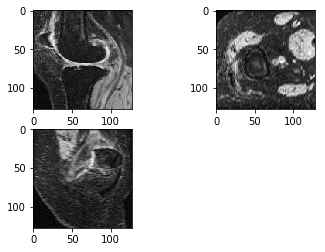

In [152]:
volumes_coronal, volumes_shape = create_numpy_volumes('data/test3d', 'coronal', img_type)
volumes_axial, volumes_shape  = create_numpy_volumes('data/test3d', 'axial', img_type)
volumes_sagittal, volumes_shape = create_numpy_volumes('data/test3d', 'sagittal', img_type)

volumes_coronal = volumes_coronal.astype('float32')
volumes_axial = volumes_axial.astype('float32')
volumes_sagittal = volumes_sagittal.astype('float32')

volumes_coronal /= 255
volumes_axial /= 255
volumes_sagittal /= 255

slice = 60

f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(volumes_sagittal[slice][:,:,0], cmap='gray')
f.add_subplot(2,2, 2)
plt.imshow(volumes_axial[slice][:,:,0], cmap='gray')
f.add_subplot(2,2, 3)
plt.imshow(volumes_coronal[slice][:,:,0], cmap='gray')
#f.add_subplot(2,2, 4)
# plt.imshow(volumes_sagittal_rs[slice], cmap='gray')
plt.show(block=True)

# Predict Labels

In [110]:
start_time = time.time()
myunet = myUnet()
model = myunet.get_unet()

print('Sagittal :')
model.load_weights('tb-sagittal-ns-acc.hdf5')
calculated_labels_sagittal = model.predict(volumes_sagittal, verbose=1)

print('Coronal :')
model.load_weights('tb-coronal-ns-acc-v12.hdf5')
calculated_labels_coronal = model.predict(volumes_coronal, verbose=1)

print('Axial :')
model.load_weights('tb-axial-ns-acc.hdf5')
calculated_labels_axial = model.predict(volumes_axial, verbose=1)

print("Time to process --- %s seconds ---" % (time.time() - start_time))

conv1 shape: (?, 128, 128, 64)
conv1 shape: (?, 128, 128, 64)
pool1 shape: (?, 64, 64, 64)
conv2 shape: (?, 64, 64, 128)
conv2 shape: (?, 64, 64, 128)
pool2 shape: (?, 32, 32, 128)
conv3 shape: (?, 32, 32, 256)
conv3 shape: (?, 32, 32, 256)
pool3 shape: (?, 16, 16, 256)


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:242: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:247: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:252: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
D:\Anaconda3\envs\tensorflow\lib\site-packages\ip

Sagittal :
104/104 [==============================] - 1s 8ms/step
Coronal :
275/275 [==============================] - 3s 9ms/step
Axial :
392/392 [==============================] - 2s 6ms/step
Time to process --- 6.747096300125122 seconds ---


# Resize and transpose volumes

D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


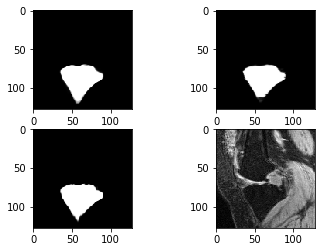

In [157]:
slice = 60
labels_coronal_rs = resize(calculated_labels_coronal, (128, 128, 128), anti_aliasing=True)
labels_coronal_tr = np.transpose(labels_coronal_rs[:,:,:,0], (2, 1, 0))


labels_axial_rs = resize(calculated_labels_axial, (128, 128, 128), anti_aliasing=True)
labels_axial_tr = np.transpose(labels_axial_rs[:,:,:,0], (1, 0, 2))


labels_sagittal_rs = resize(calculated_labels_sagittal, (128, 128, 128), anti_aliasing=True)
labels_sagittal_rs = labels_sagittal_rs[:,:,:,0]

volumes_sagittal_rs = resize(volumes_sagittal, (128, 128, 128))
volumes_sagittal_rs = volumes_sagittal_rs[:,:,:,0]


f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(labels_sagittal_rs[slice], cmap='gray')
f.add_subplot(2,2, 2)
plt.imshow(labels_axial_tr[slice], cmap='gray')
f.add_subplot(2,2, 3)
plt.imshow(labels_coronal_tr[slice], cmap='gray')
f.add_subplot(2,2, 4)
plt.imshow(volumes_sagittal_rs[slice], cmap='gray')
plt.show(block=True)

# Combine results and saves labels

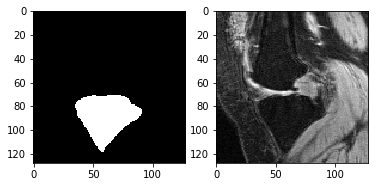

In [156]:
slice = 60

labels_combined = labels_sagittal_rs + labels_axial_tr + labels_coronal_tr

upper = 100
lower = 0
threshold = 1
labels_combined_bn = np.where(labels_combined>threshold, upper, lower)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(labels_combined_bn[slice], cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(volumes_sagittal_rs[slice], cmap='gray')
plt.show(block=True)


labels_combined_bn = labels_combined_bn.astype('float32')
volumes_sagittal_rs = volumes_sagittal_rs.astype('float32')

labels_combined_image = sitk.GetImageFromArray(labels_combined_bn)
sitk.WriteImage(labels_combined_image, "test_combined_labels_v55_ns.tif")

volumes_sagittal_image = sitk.GetImageFromArray(volumes_sagittal_rs)
sitk.WriteImage(volumes_sagittal_image, "test_volumes_v55_ns.tif")

# Import gold standard label (ski10) and prepare label from each network

Create labels...
Shape of the labels numpy array :  (104, 128, 128, 1)
Type of the array is :  uint8
Time to process --- 0.06280255317687988 seconds ---



D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


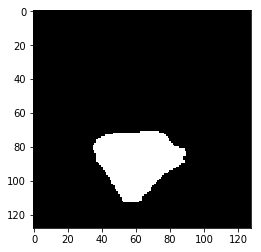

In [149]:
labels_ski10, labels_shape = create_numpy_labels('data/test3d/labels', 'sagittal', img_type)

labels_ski10 = resize(labels_ski10, (128, 128, 128), anti_aliasing=True)
plt.imshow(labels_ski10[slice][:,:,0], cmap='gray')
upper = 100
lower = 0
threshold = 0.6
labels_ski10 = np.where(labels_ski10[:,:,:,0]>threshold, upper, lower)

labels_ski10 = labels_ski10.astype('float32')


# labels_ski10_image = sitk.GetImageFromArray(labels_ski10)
# sitk.WriteImage(labels_ski10_image, "test_labels_ski10_v55.tif")

upper = 100
lower = 0
threshold = 0.5
labels_sagittal_bn = np.where(labels_sagittal_rs>threshold, upper, lower)

labels_sagittal_bn = labels_sagittal_bn.astype('float32')

plt.imshow(labels_sagittal_bn[slice], cmap='gray')

labels_sagittal_image = sitk.GetImageFromArray(labels_sagittal_bn)
#sitk.WriteImage(labels_sagittal_image, "test_sagittal_labels_v1_ns.tif")


labels_coronal_bn = np.where(labels_coronal_tr>threshold, upper, lower)

labels_coronal_bn = labels_coronal_bn.astype('float32')

plt.imshow(labels_coronal_bn[slice], cmap='gray')
#print(labels_coronal_bn[slice])
# labels_coronal_image = sitk.GetImageFromArray(labels_coronal_bn)
# sitk.WriteImage(labels_coronal_image, "test_coronal_labels_v55.tif")

labels_axial_bn = np.where(labels_axial_tr>threshold, upper, lower)

labels_axial_bn = labels_axial_bn.astype('float32')

plt.imshow(labels_axial_bn[slice], cmap='gray')


# DICE calculation

In [150]:
upper = 1
lower = 0
threshold = 0.5
labels_combined_bn = np.where(labels_combined_bn>threshold, upper, lower)
labels_ski10 = np.where(labels_ski10>threshold, upper, lower)
labels_sagittal_bn = np.where(labels_sagittal_rs>threshold, upper, lower)
labels_coronal_bn = np.where(labels_coronal_bn>threshold, upper, lower)
labels_axial_bn = np.where(labels_axial_bn>threshold, upper, lower)


#print(dice_coef(labels_combined_bn, labels_ski10))
dice = np.sum(labels_combined_bn[labels_ski10==1])*2.0 / (np.sum(labels_combined_bn) + np.sum(labels_ski10))
dice2 = np.sum(labels_sagittal_bn[labels_ski10==1])*2.0 / (np.sum(labels_sagittal_bn) + np.sum(labels_ski10))
dice3 = np.sum(labels_coronal_bn[labels_ski10==1])*2.0 / (np.sum(labels_coronal_bn) + np.sum(labels_ski10))
dice4 = np.sum(labels_axial_bn[labels_ski10==1])*2.0 / (np.sum(labels_axial_bn) + np.sum(labels_ski10))
print('Combined Dice similarity score is {}'.format(dice))
print('Sagittal Dice similarity score is {}'.format(dice2))
print('Coronal Dice similarity score is {}'.format(dice3))
print('Axial Dice similarity score is {}'.format(dice4))

Combined Dice similarity score is 0.9788395960660923
Sagittal Dice similarity score is 0.9700693540488617
Coronal Dice similarity score is 0.9694326781705422
Axial Dice similarity score is 0.9646599003971505



# Resize to original size and calculate DICE

(104, 392, 275)



D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(104, 392, 275)
(104, 392, 275)
Combined Dice similarity score is 0.9776297692795213
SAgittal Dice similarity score is 0.9627009460915581
Coronal Dice similarity score is 0.965150848853846
Axial Dice similarity score is 0.959718729917079


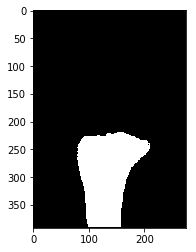

In [151]:
labels_list = glob.glob('data/test3d/labels'+"/*."+img_type) #Create a list of all labels path
labels_list.sort() #Sort alphabetically

for label_name in labels_list :
    
    #mri_label is the 3D label converted in numpy array
    (label_original, origin, spacing) = load_itk(label_name)
    print(label_original.shape)
    print()
    mask1 = label_original == 2 #Femur cartilage
    label_original[mask1] = 0

    mask2 = label_original == 4 #Tibia cartilage
    label_original[mask2] = 0

    mask3 = label_original == 1 #Femur
    label_original[mask3] = 0

    mask4 = label_original == 3 #Tibia
    label_original[mask4] = 255
    
    
plt.imshow(label_original[slice], cmap='gray')



calculated_labels_sagittal2 = resize(calculated_labels_sagittal, (label_original.shape[0], label_original.shape[1], label_original.shape[2]), anti_aliasing=True)
calculated_labels_axial2 = resize(calculated_labels_axial, (label_original.shape[1], label_original.shape[0], label_original.shape[2]), anti_aliasing=True)
calculated_labels_coronal2 = resize(calculated_labels_coronal, (label_original.shape[2], label_original.shape[1], label_original.shape[0]), anti_aliasing=True)

calculated_labels_axial_tr = np.transpose(calculated_labels_axial2[:,:,:,0], (1, 0, 2))
calculated_labels_coronal_tr = np.transpose(calculated_labels_coronal2[:,:,:,0], (2, 1, 0))
print(calculated_labels_sagittal2[:,:,:,0].shape)
print(calculated_labels_axial_tr.shape)
labels_combined_original = calculated_labels_sagittal2[:,:,:,0] + calculated_labels_axial_tr + calculated_labels_coronal_tr



upper = 1
lower = 0
threshold = 0.5
threshold2 = 1
labels_combined_original = np.where(labels_combined_original>threshold2, upper, lower)
calculated_labels_sagittal2 = np.where(calculated_labels_sagittal2>threshold, upper, lower)
calculated_labels_coronal_tr = np.where(calculated_labels_coronal_tr>threshold, upper, lower)
calculated_labels_axial_tr = np.where(calculated_labels_axial_tr>threshold, upper, lower)
label_original = np.where(label_original>threshold, upper, lower)
#print(calculated_labels_sagittal2[slice])
plt.imshow(labels_combined_original[slice], cmap='gray')

dice4 = np.sum(labels_combined_original[label_original==1])*2.0 / (np.sum(labels_combined_original) + np.sum(label_original))
dice1 = np.sum(calculated_labels_sagittal2[label_original==1])*2.0 / (np.sum(calculated_labels_sagittal2) + np.sum(label_original))
dice2 = np.sum(calculated_labels_coronal_tr[label_original==1])*2.0 / (np.sum(calculated_labels_coronal_tr) + np.sum(label_original))
dice3 = np.sum(calculated_labels_axial_tr[label_original==1])*2.0 / (np.sum(calculated_labels_axial_tr) + np.sum(label_original))
print('Combined Dice similarity score is {}'.format(dice4))
print('SAgittal Dice similarity score is {}'.format(dice1))
print('Coronal Dice similarity score is {}'.format(dice2))
print('Axial Dice similarity score is {}'.format(dice3))


# upper = 100
# lower = 0
# threshold = 0.5
# labels_combined_original = np.where(labels_combined_original>threshold, upper, lower)

# labels_combined_original = labels_combined_original.astype('float32')
# labels_combined_original_image = sitk.GetImageFromArray(labels_combined_original)
# sitk.WriteImage(labels_combined_original_image, "label_combined_original_size.tif")


# label_original = np.where(label_original>threshold, upper, lower)

# label_original = label_original.astype('float32')
# label_original_image = sitk.GetImageFromArray(label_original)
# sitk.WriteImage(label_original_image, "label_ski10_original_size.tif")